In [1]:
import math

import snntorch as snn
from snntorch import spikegen
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List
from aes_commons import *
import random

/Users/mkojro/miniforge3/envs/nn-crypto/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
config = {
    # Meta
    "no_epochs": 1,
    "batch_size" : 10_000,
    # SNN config
    "num_steps": 128,
    "beta": 0.95,
    
    # Network dimentions
    "num_inputs": 128,
    "num_spiking1": 128,
    "num_spiking2": 128,
    "num_hidden_out": 256,
    "num_outputs": 128
}

In [3]:


def bytes_to_float_array(data_block:List[uint8])->List[float]:
    result : List[float] = []
    
    for id, byte in enumerate(data_block):
        input = bin(byte)
        input = input[2:]
        input = input[::-1]
        for _ in range(8):
            result.append(0.0)

        for i, bit in enumerate(input):
            result[id * 8 + i] = float(bit)
            
    return result
print(bytes_to_float_array({uint8(6)}))

@dataclass
class CryptoDataset:

    no_bytes: int # no of bytes in ciphered message
    batch_size: int
    n :int
    
    @staticmethod
    def from_config():        
        return CryptoDataset(no_bytes=config["num_inputs"]//8,batch_size = config["batch_size"])
        
    def __init__(self,  no_bytes:int, batch_size:int):
        self.no_bytes = no_bytes
        self.batch_size = batch_size
        self.n = 0
    
    def next_sub_byte(self):
        
        label : List[uint8] = []
        for _ in range(self.no_bytes) :
            label.append(uint8(random.randint(0,255)))
        
        input : List[uint8] = mix_columns(label) 
        return (torch.FloatTensor(bytes_to_float_array(input)),torch.FloatTensor(bytes_to_float_array(label)))
    
    def __iter__(self):
        self.n = 0
        return self

    def __next__(self):
        if self.n < self.batch_size:
            self.n += 1
            return self.next_sub_byte()
        else:
            raise StopIteration
    
    

[0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [4]:

class Model(nn.Module):
    def __init__(self):
        super().__init__();
        # Initialize layers
        self.fc0 = nn.Linear(config["num_inputs"], config["num_spiking1"])
        self.fc1 = nn.Linear(config["num_spiking1"], config["num_spiking2"])
        self.lif1 = snn.Leaky(beta=config["beta"])
        self.fc2 = nn.Linear(config["num_spiking2"], config["num_hidden_out"])
        self.lif2 = snn.Leaky(beta=config["beta"])
        
        self.fc3 = nn.Linear(config["num_hidden_out"], config["num_hidden_out"])
        self.drop = nn.Dropout(p=0.1, inplace=False)
        self.fc4 = nn.Linear(config["num_hidden_out"], config["num_outputs"])

        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()

    def forward(self, x):
        # Initialize hidden state for each pass
        memory1 = self.lif1.init_leaky()
        memory2 = self.lif2.init_leaky()
        
        result_spikes = []
        result_membrain = []
        y = self.fc0(x)
        
        x = spikegen.rate(x, num_steps=config["num_steps"])
        
        spike_sum = torch.zeros(config["num_hidden_out"])
        for step in range(config["num_steps"]):
            cur1 = self.fc1(y)
            spikes1, memory1 = self.lif1(cur1, memory1)
            cur2 = self.fc2(spikes1)
            spikes2, memory2 = self.lif2(cur2, memory2)
            spike_sum += memory2
        
        spike_sum = self.sigmoid(spike_sum)
        out = self.fc3(spike_sum)
        out = self.relu(out)
        out = self.drop(out)
        out = self.fc4(out)
        out = self.relu(out)
        
        # Maybe another dense layer
        
        return self.sigmoid(out)


In [5]:
net = Model()

In [6]:
from torch.utils.data import DataLoader
train_loader = CryptoDataset.from_config()
train_loader

CryptoDataset(no_bytes=16, batch_size=10000, n=0)

In [7]:
import snntorch.spikeplot as splt

# Iterate through minibatches
data = iter(train_loader)
data_it, targets_it = next(data)

# Spiking Data
spike_data =spikegen.rate(data_it, num_steps=config["num_steps"])
spike_data.size()

torch.Size([128, 128])

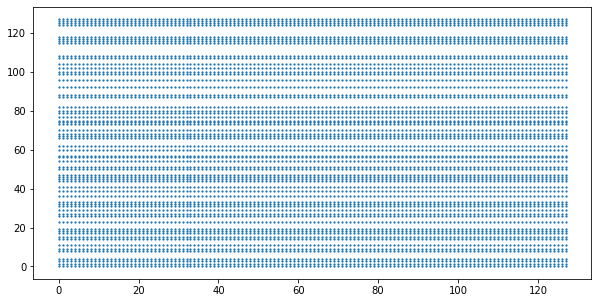

In [8]:
spike_data = spike_data[:]
spike_data_sample_plot = spike_data.reshape((config["num_steps"], -1))
fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data_sample_plot, ax, s=1.5)

In [9]:
loss_func = nn.L1Loss() # Idk
optimizer = torch.optim.Adam(net.parameters(), lr=0.0005)
loss_hist = []

In [10]:
from tqdm import tqdm
for epoch in range(config["no_epochs"]):
    for batch_idx, (x, y) in tqdm(enumerate(train_loader), total=config["batch_size"], desc=f"Epoch {epoch}"):
        net.train()
        
        # forward
        output = net(x)
        loss = loss_func(output, y)
        
        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Store loss history for future plotting
        loss_hist.append(loss.item())

Epoch 0: 100%|██████████| 10000/10000 [03:36<00:00, 46.12it/s]


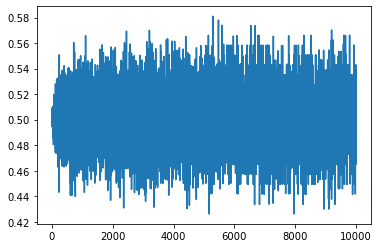

In [11]:
# plt.yscale("log")
plt.plot(loss_hist)

(array([  2.,   0.,   0.,   4.,   1.,   1.,   6.,   1.,   2.,   3.,   2.,
          1.,  14.,  11.,   2.,  10.,  11.,   9.,   6.,  52.,   3.,  10.,
         35.,   9.,  12.,  91.,  24.,  19.,  41.,  51.,  35.,  50., 136.,
         40.,  41.,  87.,  58.,  52., 304.,  94.,  44., 129.,  76.,  77.,
        282., 234.,  78., 106., 187.,  76., 107., 537., 130.,  76., 251.,
        127., 105., 522., 227., 113., 213., 205., 124., 176., 561., 110.,
        120., 247., 117., 118., 507., 125.,  97., 178., 100.,  75., 147.,
        341.,  57.,  97., 138.,  47.,  66., 283.,  47.,  48.,  95.,  37.,
         36., 122.,  70.,  22.,  43.,  44.,  25.,  28.,  90.,  11.,  19.,
         23.,   9.,   7.,  49.,   9.,   8.,  11.,  12.,   3.,   6.,  30.,
          3.,   4.,   3.,   1.,   1.,  13.,   0.,   0.,   2.,   1.,   0.,
          2.,   1.,   0.,   0.,   1.,   0.,   1.]),
 array([0.42608005, 0.4272911 , 0.42850215, 0.4297132 , 0.43092426,
        0.43213531, 0.43334636, 0.43455741, 0.43576847, 0.43697952

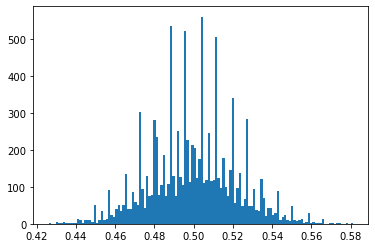

In [12]:
plt.hist(loss_hist,bins=128)

In [13]:
import numpy as np

def count_bad(input: torch.Tensor, output: torch.Tensor):
    assert len(input) == len(output)

    input = input.detach().numpy()
    output = output.detach().numpy()
    input, output = np.around(input, 0) , np.around(output, 0)
    diff = np.abs(input - output)
    return sum(diff)


a = torch.tensor([0.23, .33, .66])
b = torch.tensor([0.33, .46, .70])
c = torch.tensor([.55, .12, .1])
assert count_bad(a,b) == 0
assert count_bad(a,c) == 2

In [14]:
global_loss = .0
samples = 1000
net.eval()
with torch.no_grad():
    for index in range(samples):
        inputs, labels = train_loader.next_sub_byte()
        outputs = net(inputs)
        global_loss += count_bad(inputs, outputs) / config["num_outputs"]

config["num_outputs"] * global_loss / samples

64.169

In [15]:
import math

def binomial(k, n, p=0.5):
    """Binomial distribution with 

    Args:
        k (int): Number of successes
        n (int): Number of trials
        p (float, optional Probability of success. Defaults to 0.5.

    Returns:
        (float): Probability of exactly k successes
    """
    return (math.comb(n,k) * (p**k) * ((1-p)**(n-k)))

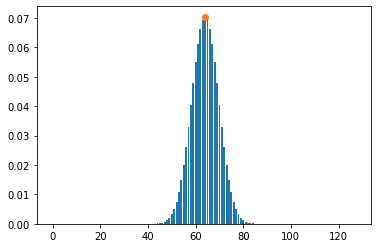

In [16]:
ok = int(config["num_outputs"] * global_loss / samples)
plt.bar(list(range(config["num_outputs"])), [binomial(i, config["num_outputs"]) for i in range(config["num_outputs"])])
plt.scatter([ok],binomial(int(ok), config["num_outputs"]))